# 2. Data exploration
 

## 2.0. Imports and high-level overview

In [1]:
import pickle
import pandas as pd
import nltk
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('deception_df.pkl')

In [3]:
df.sample(3)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id,politeness,negative_sentiment,neutral_sentiment,positive_sentiment,vader_score
13401,It was “Whose Turn is it Anyway?” in Durham.,True,True,turkey,italy,36,3,Spring,1901,3,0,"italy,turkey",11,3.029036,0.0,1.0,0.0,0.0000
15279,From venice with support from Tyr.,True,True,france,russia,1004,102,Spring,1908,7,-4,"russia,france",12,3.197687,0.0,1.0,0.0,0.4019
1733,This has been noted.,True,True,germany,england,2047,444,Fall,1907,7,2,"germany,england",1,3.341047,1.0,0.0,0.0,0.0000


In [4]:
df.describe()

,absolute_message_index,relative_message_index,game_id,politeness,negative_sentiment,neutral_sentiment,positive_sentiment,vader_score
count,17289.000000,17289.000000,17289.000000,17289.000000,17289.000000,17289.000000,17289.000000,17289.000000
mean,948.323153,113.711782,5.401990,3.335990,0.254738,0.605296,0.139966,0.195610
std,750.710891,129.367961,3.778135,0.333862,0.376942,0.420526,0.303795,0.413835
min,0.000000,0.000000,1.000000,1.349828,0.000000,0.000000,0.000000,-0.973100
25%,360.000000,22.000000,2.000000,3.168759,0.000000,0.000000,0.000000,0.000000
50%,769.000000,65.000000,4.000000,3.297227,0.000000,0.666667,0.000000,0.168000
75%,1347.000000,152.000000,9.000000,3.461842,0.500000,1.000000,0.000000,0.510600
max,3301.000000,674.000000,12.000000,4.588427,1.000000,1.000000,1.000000,0.991600


## 2.1. Overview of message politeness

### 2.1.1. Distributions

In [5]:
def plot_distribution(df, target, hue, stat="density", title=""):
    """ 
    Plots distributions (using a histogram and a KDE plot) for the reputation and ratings variable, using arxiv as a hue
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), dpi=70)
    # Reputation (don't plot KDE in same subplot as hist as it's harder to discern)
    sns.histplot(df, ax=ax, x=target, hue=hue, multiple="layer", stat=stat, common_norm=False, kde=True)

    sns.despine(fig)
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    plt.show()

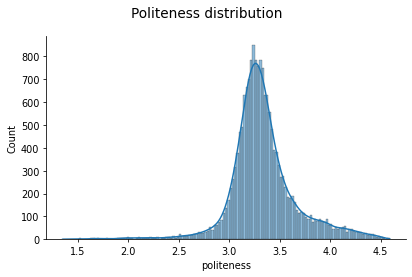

In [6]:
plot_distribution(df, target="politeness", hue=None, stat="count", title="Politeness distribution")

In [7]:
print(df.politeness.mean())
print(df.politeness.std())

3.3359897
0.33386177


#### discussion: 
We note that the politeness follows a normal distribution with parameters $\mathcal{N}(\mu,\,\sigma^{2})$ with $\mu=3.34$, $\sigma=0.33$

### 2.1.2. Message samples

* #### Least polite messages

In [8]:
for _, row in df.sort_values('politeness').head(5).iterrows():
    print(f"Score: {row['politeness']:.3f} | Message: {row['messages']}")

Score: 1.350 | Message: I will not fuck you over
Score: 1.422 | Message: What a clod you are. How in blue fuck does keeping Turkey in the game benefit you in the least.
Score: 1.449 | Message: Don’t fuck me over tho
Score: 1.468 | Message: You're a dick dude.  I will make sure that that's the last one you take.  I'll let E/G walk over me of I have to
Score: 1.477 | Message: I was getting you into Kiel. You made a bad decision, you ruined my game, and you can go fuck yourself.


* #### First quartile

In [9]:
for _, row in df.sort_values('politeness').iloc[int(len(df)/4):,:].head(5).iterrows():
    print(f"Score: {row['politeness']:.3f} | Message: {row['messages']}")

Score: 3.169 | Message: Totally understand that, I don’t want to be allied with the Turks but warring them and Russia at the same time is a pain in the ass. I’m convinced that they are against Russia and will help me until they know russia will go down (which could very well only be this fall or fall and spring)
Score: 3.169 | Message: He’s a little salty with me for the Belgium thing
Score: 3.169 | Message: Okay I’m reading your proposal again and are you saying you would get all of russia?
Score: 3.169 | Message: If France is honest with me, Ruhr will be free and Bur will be occupied. 

Let's be real here, though: Russia has at most two units to spare to threaten you, and likely not even that given the imminent pressure from Austria. I'm trying to work it out in the sandbox now but I really don't think they'd be an issue for you...
Score: 3.169 | Message: Either I build armies and funnel through Scandinavia to help you or build fleets and take on Italy.


* #### Median

In [10]:
for _, row in df.sort_values('politeness').iloc[int(len(df)/2):,:].head(5).iterrows():
    print(f"Score: {row['politeness']:.3f} | Message: {row['messages']}")

Score: 3.297 | Message: Makes sense - Germany has some guessing games in there...
Score: 3.297 | Message: I don’t have an agreement with England, but he is asking me about my moves and trying to get my help.
Score: 3.297 | Message: Night!
Score: 3.297 | Message: I'm supporting you into Nth with one fleet
Score: 3.297 | Message: Hey! Not sure yet, if you're online in an hour let's talk then.  What up with you and Russia?


* #### Third quartile

In [11]:
for _, row in df.sort_values('politeness').iloc[int(3*len(df)/4):,:].head(5).iterrows():
    print(f"Score: {row['politeness']:.3f} | Message: {row['messages']}")

Score: 3.462 | Message: Yeah, I think you'll be fine with Austria initially
Score: 3.462 | Message: You are correct, and that's why I want the army to go down there to help out silly head. Not sure where the confusion stems from.
Score: 3.462 | Message: Yeah I was thinking actually that it would make sense to put Russia into munich
Score: 3.462 | Message: Hey Italy, everything well over here. We probably won't be directly involved with each-other until mid-game, but if we're both still around, a France/Italy alliance could be pretty strong😉 .
Score: 3.462 | Message: Yeah prob either south coast or army. Im thinking an army could be good since I already have one fleet there


* #### Most polite messages

In [12]:
for _, row in df.sort_values('politeness', ascending=False).head(5).iterrows():
    print(f"Score: {row['politeness']:.3f} | Message: {row['messages']}")

Score: 4.588 | Message: Thanks, much appreciated - Hoping to work together more going forward!
Score: 4.584 | Message: Ok, thank you!
Score: 4.567 | Message: That would be great! Thanks!
Score: 4.566 | Message: Okay, thank you for letting me know. That helps!
Score: 4.554 | Message: Sounds great man! Thanks for everything!


#### discussion:
We can assess the efficiency of the chosen politeness classifier if we consider the least polite sentences to be clearly unpolite and rude, and the most polite ones to express gratitude.


### 2.1.3. Term frequency

In [13]:
 def term_count(txt, top_N):
    """Finds term frequencies for a list of words"""
    txt = txt.translate(str.maketrans('', '', string.punctuation+'’´'))
    words = nltk.tokenize.word_tokenize(txt)

    stopwords = nltk.corpus.stopwords.words('english')
    pattern = re.compile(txt, re.UNICODE | re.IGNORECASE)
    words = nltk.tokenize.word_tokenize(txt)

    words_dist = nltk.FreqDist(w for w in words if w not in stopwords+['england','russia','france','turkey','germany','italy','austria-hungary', 'austria'])

    rslt = pd.DataFrame(words_dist.most_common(top_N),
                        columns=['Word', 'Count'])
    display(rslt)

* #### Least polite messages

Term count for the 100 least polite messages

In [14]:
top_N = 10
txt = df.sort_values('politeness').head(100).messages.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
term_count(txt, top_N)

,Word,Count
0,im,29
1,fuck,27
2,fucking,15
3,shit,14
4,game,11
5,fuckin,9
6,going,9
7,dont,8
8,two,8
9,army,8


* #### Messages with median politeness

Term count for the 100 messages near the median

In [15]:
# Check for vocabulary of messages with median politeness
top_N = 10
txt = df.sort_values('politeness').iloc[int(len(df)/2) - 50: int(len(df)/2) + 50,:].messages.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
term_count(txt, top_N)

,Word,Count
0,im,27
1,want,11
2,would,11
3,sure,10
4,get,10
5,going,9
6,think,8
7,could,8
8,move,8
9,talk,7


* #### Most polite messages

Term count for the 100 most polite messages

In [16]:
# Check for most polite vocabulary
top_N = 10
txt = df.sort_values('politeness', ascending=False).head(100).messages.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
term_count(txt, top_N)

,Word,Count
0,thanks,48
1,thank,43
2,good,11
3,much,10
4,know,10
5,yes,10
6,great,8
7,help,8
8,forward,7
9,okay,7


#### Discussion:
The vocabulary used changes tremendously between the least and the most polite messages. We also noticed that the word 'Thanks' is clearly classified as very polite as the 3 first quartiles do not contain it. 

## 2.2. Overview of Stanford Sentiment Analysis and VADER score

### 2.1.1. Distributions

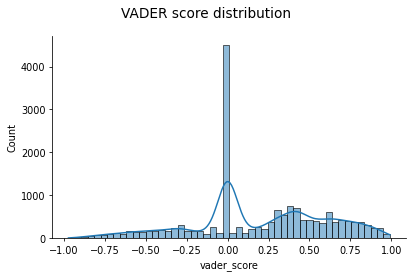

In [17]:
plot_distribution(df, target="vader_score", hue=None, stat="count", title="VADER score distribution")

#### Discussion: 
This distribution is close to gaussian, most of the sentences showing neutral sentiments and negative sentiments not being very prominent which seems weird for this kind of game where people can easily get frustrated. We surmise that negative messages do happen but are balanced by the overall positive sentiments needed for the diplomatic aspect of the game.   

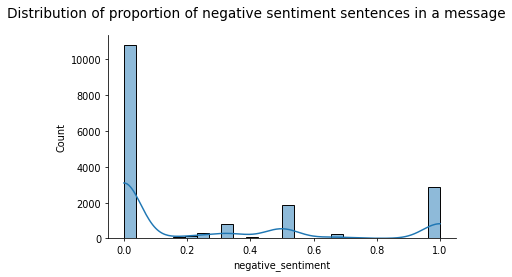

In [18]:
plot_distribution(df, target="negative_sentiment", hue=None, stat="count", title="Distribution of proportion of negative sentiment sentences in a message")

#### Discussion: 
Here we can see that when a message has negative sentiment it seems to be very negative. When a player gets frustrated all the negativity seems to end up in one or multiple very negative messages.

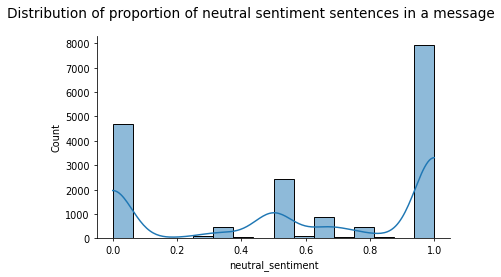

In [19]:
plot_distribution(df, target="neutral_sentiment", hue=None, stat="count", title="Distribution of proportion of neutral sentiment sentences in a message")

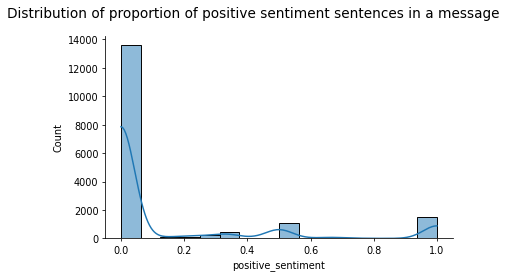

In [20]:
plot_distribution(df, target="positive_sentiment", hue=None, stat="count", title="Distribution of proportion of positive sentiment sentences in a message")

#### Discussion:
Positive sentences, just as negative ones, seem to cooccur with many other sentences of the same sentiment, whereas neutral messages are more likely to contain positive or negative sentences besides an overall neutral aspect.

* #### A few negative messages (and their  VADER score)

In [21]:
for _, row in df[df['negative_sentiment'] == 1.0].sample(10, random_state=0).iterrows():
    print(f"VADER score: {row['vader_score']:.3f} | Message: {row['messages']}")

VADER score: 0.637 | Message: As much as I love DQ, he isn't always right about everything.
VADER score: -0.557 | Message: Believe me that between him and France, I’m not trying to start shit with you
VADER score: 0.000 | Message: As long as he doesn’t move NAO to Norwegian, you’ve got a guaranteed supply center.
VADER score: -0.318 | Message: That was a lost cause
VADER score: -0.751 | Message: Berlin will be in Prussia by that time, holding Warsaw against any of our attacks and threatening your single unit covering both Moscow and St Petersburg
VADER score: 0.477 | Message: Ah, I didn't see that Italy was in Greece. Would have been wise to check the map before sending messages
VADER score: 0.000 | Message: You will have a unit in Mar and a unit in Spa if you move from LYO to Spa, there wouldn’t be anything I could take
VADER score: -0.494 | Message: I am having trouble keeping in contact with Italy, but what I want to do is work with him closely in the Med and put up a lot of fleet p

* ####  A few neutral messages (and their VADER score)

In [22]:
for _, row in df[df['neutral_sentiment'] == 1.0].sample(10, random_state=0).iterrows():
    print(f"VADER score: {row['vader_score']:.3f} | Message: {row['messages']}")

VADER score: 0.000 | Message: Is there anything you would change?
VADER score: 0.000 | Message: ???
VADER score: 0.572 | Message: Lol you choose ;)
VADER score: 0.706 | Message: Quite possibly. You'll want me to tap it anyway to help protect Vienna.
VADER score: 0.000 | Message: A bre - gas
A bur - Mar
A mar - Pie
A par - bur
F spa/sc - MAO
VADER score: 0.000 | Message: rn I'm having Moscow to sev
VADER score: 0.421 | Message: Lol
VADER score: 0.000 | Message: If you are up for it, I can move to English Channel and Mid Atlantic Ocean, and then convoy Wales to North Africa.
VADER score: 0.402 | Message: Going to support their push into Ukr
VADER score: 0.077 | Message: England told me you said I was plotting with France. It makes sense you’d want to pit us against each other.


* #### A few positive messages (and their VADER score)

In [23]:
for _, row in df[df['positive_sentiment'] == 1.0].sample(10, random_state=0).iterrows():
    print(f"VADER score: {row['vader_score']:.3f} | Message: {row['messages']}")

VADER score: 0.700 | Message: Yeah, R & T position is very strong now.
VADER score: 0.784 | Message: Awesome, thank you!
VADER score: -0.624 | Message: Ahhhh, sneaky Devil! Thank you for letting me know.
VADER score: 0.440 | Message: Good take of STP
VADER score: 0.965 | Message: Great! Sorry, I'm still new to this so when something neat occurs to me I feel the need to share my brilliant and original realisation XD
VADER score: 0.735 | Message: So ig I'm just suggesting that we stay friends until mid game where we contact one another and could have a very powerful alliance.
VADER score: 0.361 | Message: Thank you sir
VADER score: 0.765 | Message: Great, I’ll plan on the repeat bounce this spring, and it sounds like we’ll chat about it again for fall moves
VADER score: 0.178 | Message: That's funny you didn't happen to mention your aggression into Vie in your previous messages
VADER score: 0.700 | Message: I’m so happy that Italy didn’t retreat to Mao


#### DIscussion:
Here we can assess that the VADER sentiment analyzer and the stanford analyzer are not always agreeing on the sentiment classification. 
From what we observe the VADER sentiment analyzer seems to be a bit less off than the stanford one.

### 4. Study of the vocabulary distribution

* #### Negative sentiment term count

In [24]:
top_N = 15
txt = df[df['negative_sentiment'] == 1.0].messages.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
term_count(txt, 15)

,Word,Count
0,im,443
1,dont,341
2,would,228
3,like,195
4,think,194
5,get,193
6,sure,179
7,move,173
8,going,157
9,didnt,151


* #### Neutral sentiment term count

In [25]:
top_N = 15
txt = df[df['neutral_sentiment'] == 1.0].messages.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
term_count(txt, 15)

,Word,Count
0,im,840
1,support,673
2,think,610
3,would,549
4,move,508
5,get,471
6,going,468
7,like,448
8,take,432
9,want,424


* #### Positive sentiment term count

In [26]:
top_N = 15
txt = df[df['positive_sentiment'] == 1.0].messages.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
term_count(txt, 15)

,Word,Count
0,good,350
1,sounds,140
2,im,123
3,would,112
4,well,106
5,thanks,92
6,think,85
7,great,82
8,like,80
9,happy,60


#### Discussion:
We can observe some interesting things, for example: 
* neutral messages seem to be very self oriented "I'm" occuring way more than in negative and positive sentences. 
* the word 'really' is very used to express strong sentiments positive or negative.
* Besides some verbs, the vocabulary used is globally quite different between messages sentiment categories.

## 2.3. Lies, politeness and sentiment relative to year

In [27]:
df["years"] = df["years"].astype(int)
df["game_score"] = df["game_score"].astype(int)
df["game_score_delta"] = df["game_score_delta"].astype(int)

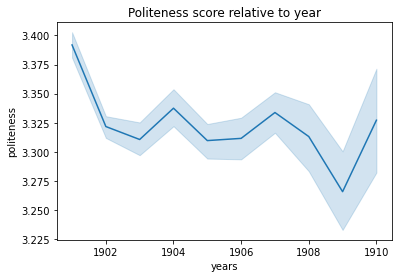

In [28]:
sns.lineplot(data=df, x="years", y="politeness")
plt.title("Politeness score relative to year")
plt.show()

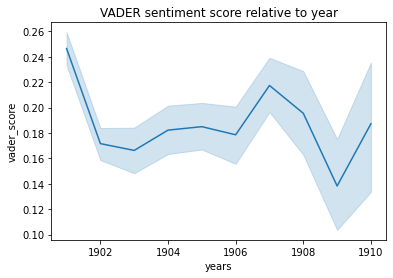

In [29]:
sns.lineplot(data=df, x="years", y="vader_score")
plt.title("VADER sentiment score relative to year")
plt.show()

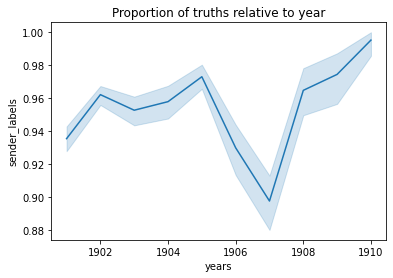

In [30]:
sns.lineplot(data=df, x="years", y="sender_labels")
plt.title("Proportion of truths relative to year")
plt.show()

#### Discussion:
This interesting plot shows a drop in people's trustworthiness around 1907. We do not really know how to explain it, but it might be the point in the game where stakes are high and where people benefit the most from betraying (close enough to the end to be able to get a solo victory, far enough from the beginning to reap most of the benefice from their alliance). 

## 2.4. Lies, politeness and sentiment relative to game score delta

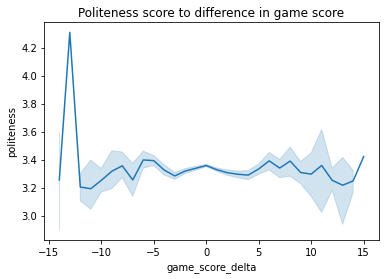

In [31]:
sns.lineplot(data=df, x="game_score_delta", y="politeness")
plt.title("Politeness score to difference in game score")
plt.show()

#### Discussion:
The politeness level, when the delta score is low, seems to be relatively high and consistent (small confidence interval). It might also be showing an imbalance in the data (most of the data having a small delta_score causing smaller confidence intervals.)

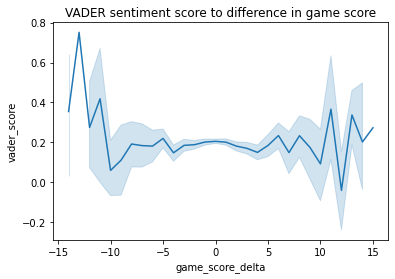

In [32]:
sns.lineplot(data=df, x="game_score_delta", y="vader_score")
plt.title("VADER sentiment score to difference in game score")
plt.show()

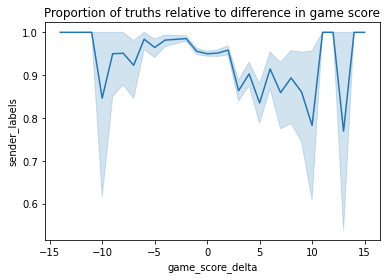

In [33]:
sns.lineplot(data=df, x="game_score_delta", y="sender_labels")
plt.title("Proportion of truths relative to difference in game score")
plt.show()

#### Discussion:
Here we can see that people in a balanced relationship tend to get a bit negligent and to perceive most of what they are told as the truth.
This changes a lot as the imbalance grows: people tend to become more careful about what they read. 

* The balanced relationship (around 0) part of the plot might be biased by the fact that each dyad starts the game at an equal game_score. With the interest of lying in the first seasons being low, this central part of the plot accounts mostly for a point in the game where lying is useless as the goal in the beginning of the game is to forge strong alliances which requires honesty.

* We can also explain the VADER sentiment score this way: the people in the beginning of the game (where score inbalance tend to be low) need to form alliances and therefore all of them use a quite similar sentimental language.